## Setup

In [0]:
# Download Dataset
!wget -qq https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/safety.zip

# Unzip Dataset
!unzip -qq safety.zip
!rm safety.zip

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# Danger Detection

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import math

### Merge Features/Labels Data (One-Time)

Retrieve data from folders and export complete dataset into **parquet** format

In [0]:
# Feature Data
feature_files = glob.glob('/content/safety/features/*.csv')
list_df = []

for filename in feature_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_df.append(df)

df_features = pd.concat(list_df, axis=0, ignore_index=True)

# Label Data
label_file = glob.glob('/content/safety/labels/*.csv')[0]
df_labels = pd.read_csv(label_file, index_col=None, header=0)

# Merge Features & Labels
df = pd.merge(df_features, df_labels, on='bookingID')

# Export to Parquet
df.to_parquet('safety_dataset.parquet.gzip', compression='gzip')

del df_features, df_labels

## Exploratory Data Analysis

**Read Dataset**

In [3]:
# Read file
df = pd.read_parquet('/gdrive/My Drive/Grab_AIForSEA_Safety/safety_dataset.parquet.gzip')

# Sort by bookingID and second
df = df.sort_values(by=['bookingID', 'second'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16154418 entries, 7815114 to 4500157
Data columns (total 12 columns):
bookingID         int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
label             int64
dtypes: float64(10), int64(2)
memory usage: 1.6 GB


In [0]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000,1
1,1202590843006,3.033,77.0,1.137217,8.975278,3.981050,0.021118,-0.022515,0.024522,541.0,0.000000,1
2,1202590843006,6.173,283.0,1.522818,7.947064,5.075056,0.137567,-0.297055,-0.017418,154.0,2.863286,1
3,1202590843006,3.014,353.0,1.134775,8.932489,3.929421,-0.007959,-0.020543,-0.022986,1384.0,0.000000,1
4,1202590843006,5.209,340.0,0.858197,9.078037,2.944571,0.061924,0.015219,0.025517,1142.0,9.750134,1


**Binary Class Distribution**

0    15007
1     4993
Name: label, dtype: int64



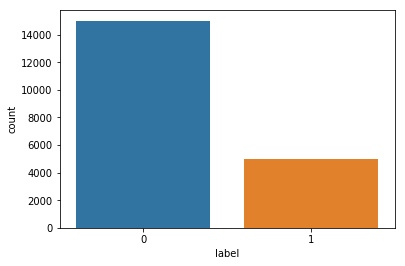

In [0]:
print(df.drop_duplicates('bookingID')['label'].value_counts())
print()
sns.countplot(x='label', data=df.drop_duplicates('bookingID'))

### Analysis of Trips

Visualization of both dangerous and safe trips

In [0]:
def plot_trips(bookingID):
  plt.style.use('ggplot')
  plt.figure(figsize=(21,10))
  cols = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'acc_magnitude', 
          'gyro_x', 'gyro_y', 'gyro_z', 'gyro_magnitude', 'Speed']
  for i, col in enumerate(cols):
    t = df[df['bookingID']==bookingID]
    if 'acc' in col:
      color='red'
    elif 'gyro' in col:
      color='green'
    else:
      color='blue'
    
    plt.subplot(math.ceil(len(cols)/4), 4, i+1)
    plt.plot(t['second'], t[col], color=color, linewidth=1.5)
    plt.title(col)

In [0]:
df.drop_duplicates('bookingID')[['bookingID', 'label']].head(10)

,bookingID,label
7815114,0,0
6953328,1,1
6785770,2,1
10448426,4,1
7218179,6,0
9508474,7,0
12355244,8,0
15769475,10,0
14606153,11,0
8050698,13,0


#### Dangerous Driving

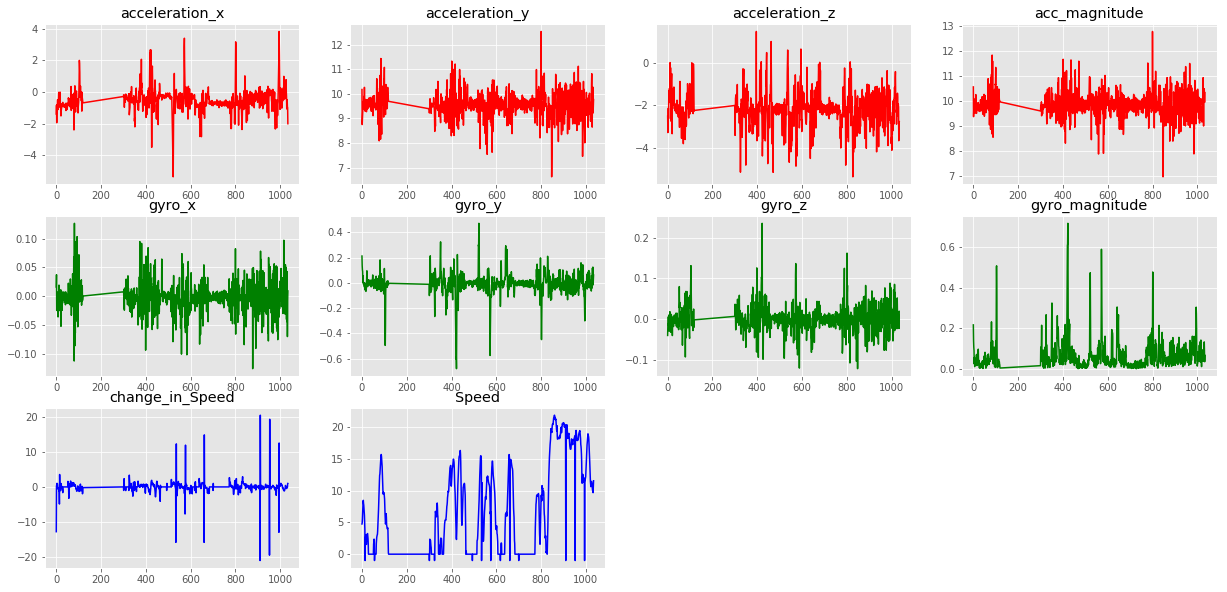

In [0]:
plot_trips(1)

#### Safe Driving

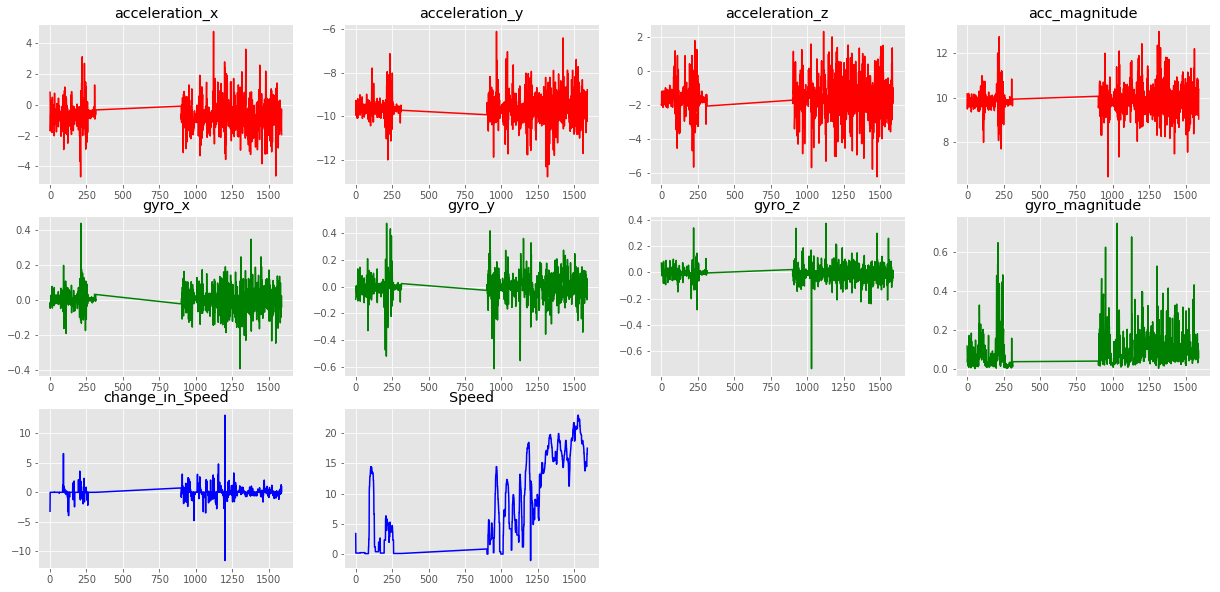

In [0]:
plot_trips(0)

## Feature Engineering

Features Engineered:
- Change in Bearing
- Change in Speed (Acceleration/Deceleration)
- Bucket Acceleration/Braking Values
- Bucket Speed values
- Magnitude of Acceleration/Gyro
- Change in Magnitude
- Total Distance Travelled in km
- No. of Danger Events Per Distance Travelled in km (Include Acceleration/Braking/Speeding Events)

Changes Made to Original Features:
- Convert Speed from m/s to km/h
- Convert Gyro from rad/s to degree/s

In [0]:
# Get Direction (North, South, East, West, North-East, North-West, South-East, South-West)
df['Direction'] = round(df['Bearing'] / 45)

# Get Change in Direction
df['change_in_Direction'] = df['Direction'] - df['Direction'].shift()

# Convert Speed from m/s to km/h
df['Speed'] = df['Speed'] * 3.6

# Convert Gyro from rad/s to degree/s
df['gyro_x'] = df['gyro_x'] * 180 / math.pi
df['gyro_y'] = df['gyro_y'] * 180 / math.pi
df['gyro_z'] = df['gyro_z'] * 180 / math.pi

# Calculate Magnitude of Acceleration and Gyro
df['acc_magnitude'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_y']**2 + df['acceleration_z']**2)
df['gyro_magnitude'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)

# Calculate linear acceleration and gyro magnitude
df['linear_acc_magnitude'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_y']**2)
df['linear_gyro_magnitude'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2)

In [0]:
# Calculate Change in Speed/Bearing/Acceleration/Gyro/Magnitude
cols = ['Speed', 'Bearing', 'Direction', 'acceleration_x', 'acceleration_y', 'acceleration_z', 
        'gyro_x', 'gyro_y', 'gyro_z', 'acc_magnitude', 'gyro_magnitude', 
        'linear_acc_magnitude', 'linear_gyro_magnitude']
for col in cols:
  df['change_in_' + col] = df[col] - df[col].shift()

# Get total distance travelled (Convert Speed in km/h to km/s)
df['distance_travelled (km)'] = df['Speed'].abs() / 3600

Change in Speed i.e Acceleration/Braking, may be performed in successions. Hence, to have a better interpretation of the change in speed, we have to determine the Acceleration/Braking done in successions

In [0]:
# Get Continuous Braking (Braking in consecutive seconds)
df['cont_braking'] = (df['change_in_Speed']<0) & (df['change_in_Speed'].shift()<0)

# Get Continuous Acceleration (Acceleration in consecutive seconds)
df['cont_acc'] = (df['change_in_Speed']>0) & (df['change_in_Speed'].shift()>0)

#### Bucketing

In [0]:
# Categorize Speed
def bucket_speed(x):
  if x <= 0:
    return np.nan
  elif x <= 20:
    return '1-20'
  elif x <= 40:
    return '21-40'
  elif x <= 60:
    return '41-60'
  elif x <= 80:
    return '61-80'
  elif x <= 100:
    return '81-100'
  elif x > 100:
    return '100+'
  else:
    return x

# Categorize Acceleration/Deceleration
def bucket_acc(x, decel=False):
  if decel == False:
    x *= -1
  if x <= 0:
    return np.nan
  elif x <= 10:
    return '1-10'
  elif x <= 20:
    return '11-20'
  elif x <= 30:
    return '21-30'
  elif x <= 40:
    return '31-40'
  elif x <= 50:
    return '41-50'
  elif x <= 60:
    return '51-60'
  elif x <= 70:
    return '61-70'
  elif x <= 80:
    return '71-80'
  elif x <= 90:
    return '81-90'
  elif x <= 100:
    return '91-100'
  elif x > -100:
    return '100+'
  else:
    return x

df['speed_category'] = df['Speed'].apply(bucket_speed)
df['acc_category'] = df['change_in_Speed'].apply(lambda x: bucket_acc(x, decel=False))
df['braking_category'] = df['change_in_Speed'].apply(lambda x: bucket_acc(x, decel=True))

**One Hot Encode Categorical Features**

The above categorical features created from bucketing, will be one-hot encoded. It will then be summed across each columns (grouped by bookingID) later on

In [0]:
s = pd.get_dummies(df['speed_category'], prefix='Speed')
df = pd.concat([df, s], axis=1)
df = df.drop('speed_category', axis=1)

s = pd.get_dummies(df['acc_category'], prefix='acc_category')
df = pd.concat([df, s], axis=1)
df = df.drop('acc_category', axis=1)

s = pd.get_dummies(df['braking_category'], prefix='braking')
df = pd.concat([df, s], axis=1)
df = df.drop('braking_category', axis=1)

#### Aggregation
Aggregate Features By BookingID:
- Avg./Max./Min. Acceleration/Gyro/Speed
- Avg./Max./Min. Change in Acc./Gyro/Speed/Bearing
- No. of Increase/Decrease in Acceleration/Gyro/Bearing/Speed

In [0]:
# Aggregate all features grouped by BookingID (Mean, Max., Min.)
agg_dict = {}
for col in df.columns:
    if col in ['bookingID', 'Bearing', 'label']:
      continue
    elif col == 'second':
      agg_dict[col] = 'max'
    elif col in ['Accuracy', 'Direction', 'change_in_Direction']:
      agg_dict[col] = 'mean'
    elif col in ['distance_travelled (km)', 'cont_acc', 'cont_braking', 'sudden_braking']:
      agg_dict[col] = 'sum'
    elif col.startswith('acc_category') or col.startswith('braking') or col.startswith('Speed_'):
      agg_dict[col] = 'sum'
    else:
      agg_dict[col] = 'mean'

df2 = df.groupby(by=['bookingID', 'label']).agg(agg_dict).reset_index()

**Determine Danger Events Per Km**
- Number of Danger Events / Distance Travelled in km

In [0]:
df2['danger_events_per_km'] = df2.drop(['Speed_1-20', 'acc_category_1-10', 'braking_1-10'], axis=1).iloc[:, 32:].sum(axis=1) / df2['distance_travelled (km)']

## Machine Learning

XGBoost Classifier will be used in order to tackle the non-linearity within the data

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### Imputation

Impute Missing Values after Aggregation of Features
- Imputation will be made with constant value of 0

In [63]:
# Find columns with missing values (Null values not included within Count stats)
# Columns with count values less than length of dataframe contains missing values
s = df2.describe().loc['count']
s[s < len(df2)]

danger_events_per_km    20017.0
Name: count, dtype: float64

In [0]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='constant', fill_value=0)
X = imputer.fit_transform(df2.drop(['bookingID', 'label'], axis=1))
y = df2['label']

### Train Test Split

In [0]:
# X = df2.drop(['bookingID', 'label'], axis=1)
y = df2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=7)

### Evaluation

#### Stratified K-Fold Cross Validation

Perform Cross Validation to ensure that the model performs consistently across entire dataset

In [0]:
kfold = StratifiedKFold(5, shuffle=True, random_state=7)

clf = XGBClassifier(scale_pos_weight=len(y[y==0])/len(y[y==1]))
result = cross_val_score(clf, X, y, scoring='f1_macro', cv=kfold)
print("Cross Validation Result:", result)
print("Mean Score:", result.mean())

Cross Validation Result: [0.64772343 0.63633287 0.62720455 0.63152404 0.63893155]
Mean Score: 0.6363432891075769


#### Classification Report

The model is observed to be poor in identifying dangerous driving behaviors. There are several factors that could lead to this issue:
- Imbalanced Class Distribution
- Insufficient Features to distinguish dangerous driving from safe driving

In [73]:
clf = XGBClassifier(scale_pos_weight=len(y[y==0])/len(y[y==1]))

clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      4506
           1       0.42      0.59      0.49      1500

    accuracy                           0.69      6006
   macro avg       0.63      0.66      0.63      6006
weighted avg       0.74      0.69      0.71      6006



#### Confusion Matrix

Text(0.5, 24.0, 'Predicted label')

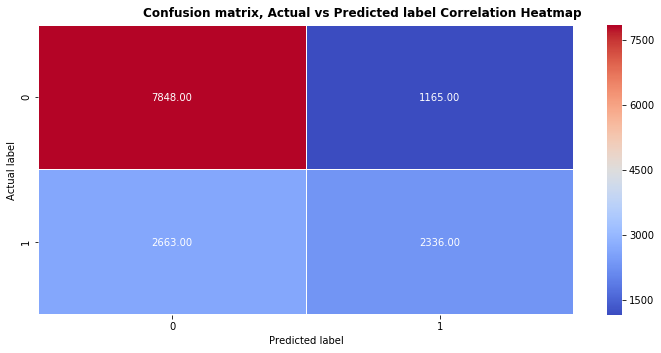

In [80]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.heatmap(pd.DataFrame(confusion_matrix(clf.predict(X_train), y_train)),
            ax = ax,
            cmap = 'coolwarm',
            annot = True,
            fmt = '.2f',
            linewidths = 0.05)
fig.subplots_adjust(top=0.93)
fig.suptitle('Confusion matrix, Actual vs Predicted label Correlation Heatmap', 
              fontsize=12, 
              fontweight='bold')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Feature Importance

In [0]:
importances = clf.feature_importances_
cols = df2.drop(['bookingID', 'label'], axis=1).columns
feature_importances = pd.DataFrame(importances, index=cols, columns = ['importance'])

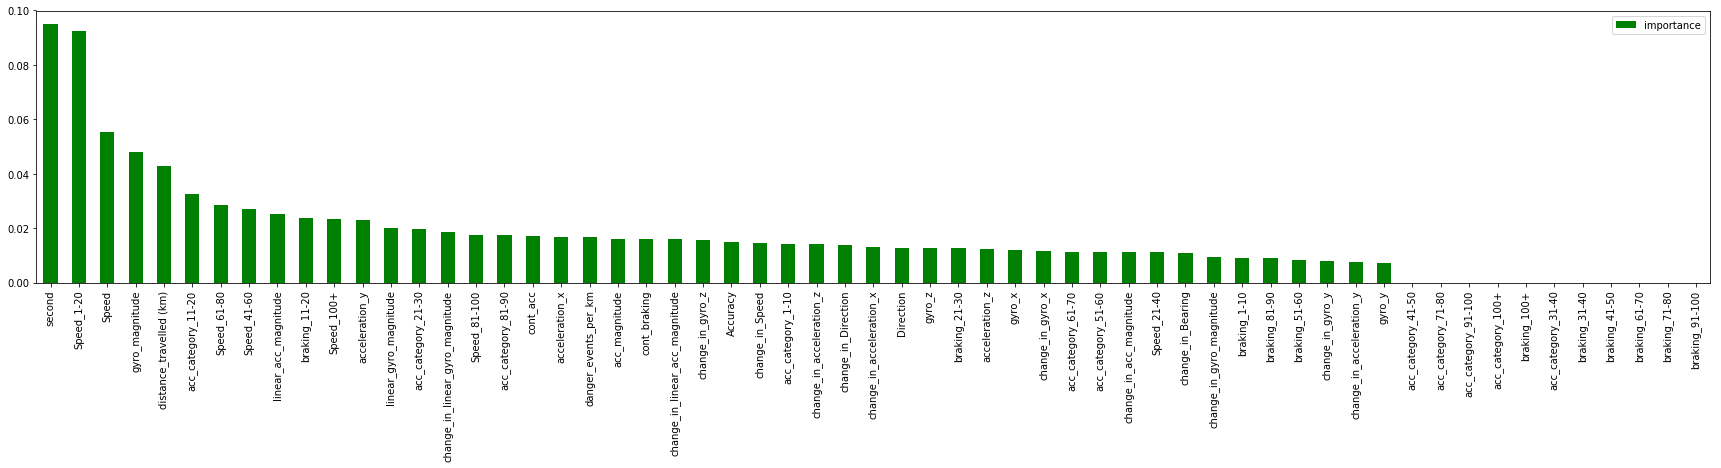

In [92]:
feature_importances.sort_values('importance', ascending = False).plot(kind = 'bar',
                                                                      figsize = (30,5),
                                                                      color = 'g',
                                                                      align = 'center')
plt.xticks(rotation=90)
plt.show()

### Hyper-Parameter Tuning

In [0]:
from sklearn.model_selection import GridSearchCV

In [122]:
params = {
    "n_estimators": [75, 100, 125],
    "learning_rate": [0.10, 0.20, 0.30],
    "max_depth": [3, 5, 8]
}

clf = XGBClassifier(scale_pos_weight=len(y[y==0])/len(y[y==1]))
grid = GridSearchCV(clf, params, scoring='f1_macro', cv=kfold)
grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=3.0027994401119775,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0

In [123]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75}

In [124]:
kfold = StratifiedKFold(5, shuffle=True, random_state=7)

clf = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=75, scale_pos_weight=len(y[y==0])/len(y[y==1]))
result = cross_val_score(clf, X, y, scoring='f1_macro', cv=kfold)
print("Cross Validation Result:", result)
print("Mean Score:", result.mean())

Cross Validation Result: [0.65266398 0.63205566 0.63128609 0.63340213 0.63799176]
Mean Score: 0.6374799229336309
